In [35]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn import neighbors

import statsmodels.formula.api as smf

import seaborn as sns

In [36]:
#Load data and specific set of columns of interest
df = pd.read_csv('nyc-rolling-sales.csv')
df_sales = df.loc[(df['SALE PRICE'].replace(' -  ','0').astype(float) > 0.00),['BOROUGH','RESIDENTIAL UNITS','COMMERCIAL UNITS','GROSS SQUARE FEET','LAND SQUARE FEET','SALE PRICE']]


In [37]:

#SALE PRICE, LAND AND GROSS SQUARE FEET, AND RESIDENTIAL UNITS ARE object but should be numeric
df_sales['SALE PRICE'] = pd.to_numeric(df_sales['SALE PRICE'], errors='coerce')
df_sales['LAND SQUARE FEET'] = pd.to_numeric(df_sales['LAND SQUARE FEET'], errors='coerce')
df_sales['GROSS SQUARE FEET']= pd.to_numeric(df_sales['GROSS SQUARE FEET'], errors='coerce')
df_sales['RESIDENTIAL UNITS']= pd.to_numeric(df_sales['RESIDENTIAL UNITS'], errors='coerce')
df_sales['log_sale_price']=np.log(df_sales['SALE PRICE'])
df_sales['GSF_PER_RU']=df_sales['GROSS SQUARE FEET']/df_sales['RESIDENTIAL UNITS']

#Update Boroughs
df_sales['BOROUGH'][df_sales['BOROUGH'] == 1] = 'Manhattan'
df_sales['BOROUGH'][df_sales['BOROUGH'] == 2] = 'Bronx'
df_sales['BOROUGH'][df_sales['BOROUGH'] == 3] = 'Brooklyn'
df_sales['BOROUGH'][df_sales['BOROUGH'] == 4] = 'Queens'
df_sales['BOROUGH'][df_sales['BOROUGH'] == 5] = 'Staten Island'

   
#Remove outliers
df_sales_nonoutliers = df_sales[(df_sales['SALE PRICE'] > 100000) & (df_sales['SALE PRICE'] < 5000000) & (df_sales['RESIDENTIAL UNITS'] > 0) & (df_sales['GROSS SQUARE FEET'] > 0) & (df_sales['GROSS SQUARE FEET'] < 10000)]

#drop gross square feet and residential units now that GSF_PER-RU is created
df_sales_nonoutliers.drop(columns=['GROSS SQUARE FEET'], axis=1, inplace=True)
 
#Add Dummies

#df_sales_nonoutliers = pd.get_dummies(df_sales_nonoutliers)

#Drop non-numeric rows
#df_sales_nonoutliers = df_sales_nonoutliers.select_dtypes(include=[np.number]).dropna()





C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus

In [41]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
X = df_sales_nonoutliers[['RESIDENTIAL UNITS','COMMERCIAL UNITS','GSF_PER_RU','LAND SQUARE FEET','SALE PRICE']]
Y = df_sales_nonoutliers['BOROUGH']

X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv=10, scoring='accuracy')

array([0.60139319, 0.55766254, 0.55147059, 0.52071235, 0.49883721,
       0.48062016, 0.49612403, 0.45852713, 0.58084529, 0.53702986])

In [42]:
corrmat = df_sales_nonoutliers.corr()

In [43]:
corrmat_transposed = corrmat.stack().reset_index()
corrmat_transposed.columns = ['col1', 'col2', 'correlation']
highly_correlated = corrmat_transposed.loc[(corrmat_transposed['col1'] != corrmat_transposed['col2']) & 
                                           (corrmat_transposed['correlation'].abs() > .9)]
highly_correlated.sort_values('correlation', ascending=False)

keep = []
remove = []

for index, row in highly_correlated.iterrows():
    if row['col1'] not in keep and row['col1'] not in remove:
        keep.append(row['col1'])
    if row['col2'] not in keep and row['col2'] not in remove:
        remove.append(row['col2'])
    

In [49]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
X = df_sales_nonoutliers[['RESIDENTIAL UNITS','COMMERCIAL UNITS','GSF_PER_RU','LAND SQUARE FEET','SALE PRICE']].drop(remove, 1)
Y = df_sales_nonoutliers['BOROUGH']

X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv=10)
#.mean()

0.5258049995904043

In [51]:
rfc.fit(X,Y)
test = pd.DataFrame(np.column_stack((rfc.predict(X),Y)))
test.to_csv('compare.csv')

PermissionError: [Errno 13] Permission denied: 'compare.csv'

In [47]:
df_sales_nonoutliers.groupby('BOROUGH').count()

,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,SALE PRICE,log_sale_price,GSF_PER_RU
BOROUGH,,,,,,
Bronx,3034,3034,3034,3034,3034,3034
Brooklyn,7574,7574,7574,7574,7574,7574
Manhattan,238,238,238,238,238,238
Queens,10204,10204,10204,10204,10204,10204
Staten Island,4763,4763,4763,4763,4763,4763


Feature ranking:
1. feature SALE PRICE (0.327989)
2. feature LAND SQUARE FEET (0.309603)
3. feature GSF_PER_RU (0.293334)
4. feature RESIDENTIAL UNITS (0.058884)
5. feature COMMERCIAL UNITS (0.010191)


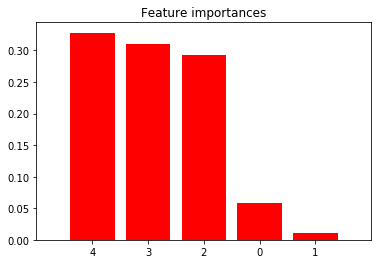

In [56]:


importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a classification task using 3 informative features
X, y = make_classification(n_samples=1000,
                           n_features=10,
                           n_informative=3,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           random_state=0,
                           shuffle=False)

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()